In [5]:
#current_dir = pwd()
#app_dir = "/app"
#cd(app_dir)

#push!(LOAD_PATH, app_dir)
#push!(LOAD_PATH, current_dir)
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel")

using Gen
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN

include("docker-parallel/NUTS.jl")
include("docker-parallel/RJNUTS.jl")
include("docker-parallel/utils.jl")
include("docker-parallel/proposals.jl")
include("docker-parallel/LoadData.jl");

In [2]:
println(Threads.nthreads())

4


In [3]:
function RJNUTS_parallel2(trace, chain, ci)
    
    (trace, a_acc) = layer_parameter(trace)
    trace  = gibbs_hyperparameters(trace)
    trace  = gibbs_noise(trace)
    (trace, w_acc)  = layer_nuts(trace)
    #(trace, w_acc) = nuts_parameters(trace)
    println("Chain $chain Iter $ci : $(get_score(trace))")

    return trace, a_acc, w_acc
end;

In [33]:
function write_output()
    for i=1:CHAINS
        current_file = join([filename_pre,"$i", filename_end])
        serialize(current_file, traces[i])
    end
end;

In [3]:
#MAIN SIMULATION

include("docker-parallel/RJNUTS.jl")
include("docker-parallel/utils.jl")
println("Packages Loaded")

filename = "testparallel.jld"
filename_pre = "trace"
filename_end = "output.jld"
ITERS = 10
CHAINS = Threads.nthreads()

#---------------
#Hyperparameters
#---------------

#NUTS hyperparameters
Δ_max = 100
acc_prob = 0.15
m=1
m2=1

#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real; #Hidden & Output Weights Scale

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

#-----------
#Parallelize
#-----------

println("Initializing Traces")
println("-------------------")

traces = [[] for i=1:CHAINS]
a_acc = [[] for i=1:CHAINS]
w_acc = [[] for i=1:CHAINS]

for i=1:CHAINS
    obs[:l] = ((i-1)%8 + 1)
    #(new_start,) = generate(interpolator, (x_train,), obs)
    new_start = find_best_trace(x_train,y_train,1000,obs)
    score = get_score(new_start)
    println("Chain $i starting score: $score")
    push!(traces[i],new_start)
end

active_trace = [traces[i][1] for i=1:CHAINS]
a_active = [[] for i=1:CHAINS]
w_active = [[] for i=1:CHAINS]

obs = obs_master;
println([traces[i][1][:l] for i=1:CHAINS])

Packages Loaded
Initializing Traces
-------------------
Chain 1 starting score: -473.5031595473336
Chain 2 starting score: -751.4651425564474
Chain 3 starting score: -557.2148841305553
Chain 4 starting score: -522.7338440985347
[1, 2, 3, 4]


In [6]:
#--------------
#Run Inference
#--------------
#cd(current_dir)
println("Beginning Inference")
println("-------------------")
#traces, scores = RJNUTS(trace, ITERS)

try
    Threads.@threads for i=1:CHAINS
        @inbounds for i2=1:ITERS
            active_trace[i],_,_ = RJNUTS_parallel(traces[i][i2], i, i2)
            push!(traces[i],active_trace[i])
            push!(a_acc[i],a_active[i])
            push!(w_acc[i],w_active[i])
        end
        flush(stdout)
        #serialize(filename, traces)
    end
finally
    write_output()
end

Beginning Inference
-------------------
Chain 1 Iter 1 : -409.0464972173688
Chain 1 Iter 2 : -391.503428091891
Chain 2 Iter 1 : -434.27995651718817
Chain 2 Iter 2 : -406.4446903851532
Chain 3 Iter 1 : -505.0913983358673
Chain 3 Iter 2 : -501.2692384296353
Chain 1 Iter 3 : -404.6571758359953
Chain 1 Iter 4 : -384.4385676874225
Chain 3 Iter 3 : -503.93177749933216
Chain 3 Iter 4 : -501.5699186047216
Chain 3 Iter 5 : -491.9526251331986
Chain 4 Iter 1 : -502.632248902687
Chain 3 Iter 6 : -485.6810545122938


TaskFailedException: TaskFailedException:
InterruptException:
Stacktrace:
 [1] copy at ./array.jl:352 [inlined]
 [2] copy_oftype at /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/LinearAlgebra.jl:347 [inlined]
 [3] cholcopy at /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/cholesky.jl:139 [inlined]
 [4] #cholesky#136 at /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/cholesky.jl:348 [inlined]
 [5] cholesky at /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/cholesky.jl:348 [inlined] (repeats 2 times)
 [6] PDMat at /home/jberez/.julia/packages/PDMats/G0Prn/src/pdmat.jl:19 [inlined]
 [7] inv(::PDMats.PDMat{Float64,Array{Float64,2}}) at /home/jberez/.julia/packages/PDMats/G0Prn/src/pdmat.jl:56
 [8] invcov at /home/jberez/.julia/packages/Distributions/jFoHB/src/multivariate/mvnormal.jl:261 [inlined]
 [9] logpdf_grad at /home/jberez/.julia/packages/Gen/5N1x4/src/modeling_library/distributions/mvnormal.jl:21 [inlined]
 [10] special_reverse_exec!(::ReverseDiff.SpecialInstruction{Gen.MultivariateNormal,Tuple{Array{Float64,1},Array{Float64,1},Diagonal{Float64,Array{Float64,1}}},ReverseDiff.TrackedReal{Float64,Float64,Nothing},Nothing}) at /home/jberez/.julia/packages/Gen/5N1x4/src/dynamic/backprop.jl:10
 [11] reverse_exec!(::ReverseDiff.SpecialInstruction{Gen.MultivariateNormal,Tuple{Array{Float64,1},Array{Float64,1},Diagonal{Float64,Array{Float64,1}}},ReverseDiff.TrackedReal{Float64,Float64,Nothing},Nothing}) at /home/jberez/.julia/packages/ReverseDiff/jFRo1/src/tape.jl:93
 [12] reverse_pass!(::Array{ReverseDiff.AbstractInstruction,1}) at /home/jberez/.julia/packages/ReverseDiff/jFRo1/src/tape.jl:87
 [13] reverse_pass! at /home/jberez/.julia/packages/Gen/5N1x4/src/backprop.jl:12 [inlined]
 [14] choice_gradients(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}, ::DynamicSelection, ::Nothing) at /home/jberez/.julia/packages/Gen/5N1x4/src/dynamic/backprop.jl:382
 [15] (::var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap})(::Array{Float64,1}) at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:23
 [16] leapfrog at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:31 [inlined]
 [17] (::var"#build_tree#56"{var"#L#52"{Tuple{Transpose{Float64,Array{Float64,2}}},Tuple{NoChange},DynamicChoiceMap},var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap},var"#leapfrog#54"{var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap}}})(::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Int64, ::Float64, ::Array{Float64,1}, ::Array{Float64,1}) at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:62
 [18] (::var"#build_tree#56"{var"#L#52"{Tuple{Transpose{Float64,Array{Float64,2}}},Tuple{NoChange},DynamicChoiceMap},var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap},var"#leapfrog#54"{var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap}}})(::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Int64, ::Float64, ::Array{Float64,1}, ::Array{Float64,1}) at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:74 (repeats 2 times)
 [19] (::var"#build_tree#56"{var"#L#52"{Tuple{Transpose{Float64,Array{Float64,2}}},Tuple{NoChange},DynamicChoiceMap},var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap},var"#leapfrog#54"{var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap}}})(::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Int64, ::Float64, ::Array{Float64,1}, ::Array{Float64,1}) at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:77 (repeats 3 times)
 [20] (::var"#build_tree#56"{var"#L#52"{Tuple{Transpose{Float64,Array{Float64,2}}},Tuple{NoChange},DynamicChoiceMap},var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap},var"#leapfrog#54"{var"#∇L#53"{DynamicSelection,Tuple{Transpose{Float64,Array{Float64,2}}},Nothing,Tuple{NoChange},DynamicChoiceMap}}})(::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Int64, ::Float64, ::Array{Float64,1}, ::Array{Float64,1}) at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:74
 [21] NUTS(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}, ::DynamicSelection, ::Float64, ::Int64, ::Int64, ::Bool) at /home/jberez/Projects/BostonHousing/docker-parallel/NUTS.jl:115
 [22] layer_nuts(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}, ::String) at /home/jberez/Projects/BostonHousing/docker-parallel/RJNUTS.jl:108
 [23] layer_parameter(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at /home/jberez/Projects/BostonHousing/docker-parallel/RJNUTS.jl:153
 [24] RJNUTS_parallel(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}, ::Int64, ::Int64) at /home/jberez/Projects/BostonHousing/docker-parallel/RJNUTS.jl:199
 [25] macro expansion at ./In[6]:12 [inlined]
 [26] (::var"#505#threadsfor_fun#74"{UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [27] (::var"#505#threadsfor_fun#74"{UnitRange{Int64}})() at ./threadingconstructs.jl:28

Chain 3 Iter 7 : -482.65061586122533


In [7]:
recovered = []
for i=1:CHAINS
    current_file = join([filename_pre,"$i", filename_end])
    push!(recovered, deserialize(current_file))
end;

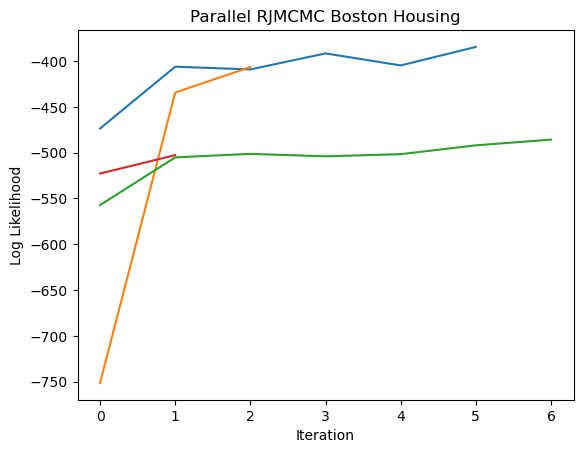

Chain 2 Iter 3 : -397.7376511211198
Chain 3 Iter 8 : -471.9532367783729
Chain 2 Iter 4 : -389.4909839614667
Chain 2 Iter 5 : -386.0291659660945
Chain 4 Iter 2 : -500.6502510850544
Chain 2 Iter 6 : -378.2034398215478
Chain 2 Iter 7 : -377.59412565627997
Chain 2 Iter 8 : -378.31600205537535
Chain 4 Iter 3 : -481.2402778169561
Chain 2 Iter 9 : -379.4406051715602
Chain 2 Iter 10 : -376.44651564195254
Chain 4 Iter 4 : -475.4313829769724
Chain 4 Iter 5 : -469.50748061150216
Chain 4 Iter 6 : -467.7440013523659
Chain 4 Iter 7 : -459.8652901614187
Chain 4 Iter 8 : -458.2255666320351
Chain 4 Iter 9 : -458.85684995630106
Chain 4 Iter 10 : -458.9999305620237


In [8]:
#Plot Log Posterior for Each Chain
traces = recovered

using PyPlot

for i=1:CHAINS
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores)
end
plt.title("Parallel RJMCMC Boston Housing")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
#plt.ylim(-2000,0)

#plt.legend();